In [5]:
# Libraries
import pandas as pd, numpy as np, seaborn as sn, matplotlib.pyplot as plt, ipywidgets as widgets
from sklearn.model_selection import train_test_split
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn import metrics, preprocessing

## Fitur Utama Prabu

In [6]:
# Load the dataset
try:
    companies_df = pd.read_csv('PrabuModule/one-hot-credit-risk.tar.gz', compression='gzip')
except FileNotFoundError:
    print("File 'PrabuModule/one-hot-credit-risk.tar.gz' not found. Please ensure the dataset is in the correct location.")
    # Fallback atau tindakan lain jika file tidak ditemukan, misalnya menghentikan eksekusi atau menggunakan data dummy lain
    companies_df = pd.DataFrame() # Buat DataFrame kosong untuk menghindari error lebih lanjut

# Fix the unbalanced case for MScore.2019.int (digunakan untuk balancing awal)
if not companies_df.empty and 'MScore.2019.int' in companies_df.columns:
    high_risk_df = companies_df[companies_df['MScore.2019.int'] == 1]
    low_risk_df = companies_df[companies_df['MScore.2019.int'] == 0]
    
    if not high_risk_df.empty and not low_risk_df.empty:
        # Sample from the larger class to match the smaller class, or sample with a fixed size / ratio
        # Original notebook samples from low_risk to match high_risk count.
        if len(low_risk_df) >= len(high_risk_df):
            low_risk_df_sampled = low_risk_df.sample(n=len(high_risk_df), random_state=0)
            restricted_df = pd.concat([low_risk_df_sampled, high_risk_df])
        else: # Jika high_risk_df lebih banyak, sample dari high_risk_df
            high_risk_df_sampled = high_risk_df.sample(n=len(low_risk_df), random_state=0)
            restricted_df = pd.concat([low_risk_df, high_risk_df_sampled])
        restricted_df.sort_index(inplace=True)
    else:
        print("Tidak cukup data di salah satu kelas MScore.2019.int untuk balancing. Menggunakan companies_df tanpa balancing.")
        restricted_df = companies_df.copy() # Gunakan copy agar tidak mengubah companies_df asli
else:
    print("companies_df kosong atau tidak memiliki kolom 'MScore.2019.int'. restricted_df akan kosong.")
    restricted_df = pd.DataFrame() # Buat DataFrame kosong

print(f"Shape of companies_df: {companies_df.shape}")
print(f"Shape of restricted_df after initial balancing: {restricted_df.shape}")

Shape of companies_df: (121008, 79)
Shape of restricted_df after initial balancing: (24320, 79)


In [7]:
import joblib
import pandas as pd
import numpy as np
from ipywidgets import IntSlider, FloatSlider, Label, VBox, HBox, Layout
import ipywidgets as widgets
import matplotlib.pyplot as plt
from PrabuModule.dummy_data_prabu import get_dummy_data # Impor fungsi dari file data dummy

# Load model dari file joblib
best_model = joblib.load("PrabuModule/PrabuModel.joblib")

# ---- Integrasi Data Dummy ----
# Tentukan tahun dasar untuk fitur (misal 2018 untuk prediksi 2019)
base_year_for_features = 2018 
year_to_predict = base_year_for_features + 1

# Hasilkan data dummy menggunakan fungsi dari dummy_data_prabu.py
# Anda bisa mengubah n_samples jika ingin menguji dengan lebih banyak data
dummy_df_full = get_dummy_data(year_value=base_year_for_features, n_samples=10)

# Pisahkan fitur (X) dan target (y) dari data dummy
# Target di sini adalah 'MScore.{year_to_predict}.int'
X_dummy_test = dummy_df_full.drop(columns=[f'MScore.{year_to_predict}.int'])
y_dummy_test_actual = dummy_df_full[f'MScore.{year_to_predict}.int'] # Ini target sebenarnya, bisa untuk evaluasi

# Ambil satu sampel data untuk demonstrasi fitur Prabu
# Kita akan menggunakan baris pertama dari X_dummy_test
if not X_dummy_test.empty:
    sample_applicant_data = X_dummy_test.iloc[[0]]
    # Karena kita pakai data dummy, nama perusahaan bisa dibuat generik
    # atau jika Anda menambahkan kolom 'Company Name' di get_dummy_data, Anda bisa menggunakannya
    company_name_sample = f"Perusahaan Dummy ID {sample_applicant_data.index[0]}" 
else:
    print("Gagal menghasilkan data dummy. Menggunakan fallback.")
    # Fallback jika get_dummy_data gagal (seharusnya tidak terjadi)
    # Kolom ini harus SAMA PERSIS dengan yang ada di dummy_data_prabu.py bagian _sectors dan _countries
    feature_columns = ['MScore.2018.int', 'Turnover.2018', 'EBIT.2018', 'PLTax.2018', 'Leverage.2018', 'ROE.2018', 'TAsset.2018'] + \
                      ['Automobiles and Components', 'Banks', 'Capital Goods', 'Commercial and Professional Services',
                       'Consumer Durables and Apparel', 'Consumer Services', 'Diversified Financials',
                       'Energy', 'Food Beverage and Tobacco', 'Food and Staples Retailing',
                       'Health Care Equipment and Services', 'Household and Personal Products',
                       'Insurance', 'Materials', 'Media and Entertainment', 'Pharmaceuticals Biotechnology and Life Sciences',
                       'Real Estate', 'Retailing', 'Semiconductors and Semiconductor Equipment',
                       'Software and Services', 'Technology Hardware and Equipment',
                       'Telecommunication Services', 'Transportation', 'Utilities'] + \
                      ['France', 'Germany', 'Italy', 'Netherlands', 'Spain', 'United Kingdom', 
                       'Other_European_Countries', 'North_America', 'Asia_Pacific', 'Rest_of_the_World']

    dummy_data_fallback = np.random.rand(1, len(feature_columns))
    sample_applicant_data = pd.DataFrame(dummy_data_fallback, columns=feature_columns)
    company_name_sample = "Perusahaan Fallback Dummy"

    # Filter dan urutkan kolom sample_applicant_data agar sesuai dengan yang diharapkan model
    if hasattr(best_model, 'feature_names_in_'):
        model_features = best_model.feature_names_in_
        # Pastikan semua fitur model ada di sample_applicant_data (isi dengan 0 jika tidak ada)
        for col in model_features:
            if col not in sample_applicant_data.columns:
                sample_applicant_data[col] = 0 # atau np.nan
        sample_applicant_data = sample_applicant_data[model_features] # Select and reorder
    elif hasattr(best_model, 'n_features_in_') and not hasattr(best_model, 'feature_names_in_'): 
        # Untuk model sklearn versi lama yang tidak menyimpan feature_names_in_
        # Kita asumsikan feature_columns di atas sudah benar urutannya dan jumlahnya
        if sample_applicant_data.shape[1] != best_model.n_features_in_:
            print(f"Peringatan: Jumlah kolom data fallback ({sample_applicant_data.shape[1]}) tidak cocok dengan jumlah fitur model ({best_model.n_features_in_}). Prediksi mungkin gagal atau tidak akurat.")
            if sample_applicant_data.shape[1] > best_model.n_features_in_:
                 sample_applicant_data = sample_applicant_data.iloc[:, :best_model.n_features_in_]
            # Jika kurang, mungkin perlu padding dengan nol, tapi ini sangat berisiko tanpa nama kolom
            # else: sample_applicant_data = pd.concat([sample_applicant_data, pd.DataFrame(np.zeros((1, best_model.n_features_in_ - sample_applicant_data.shape[1])), columns=[f'dummy_col_{i}' for i in range(best_model.n_features_in_ - sample_applicant_data.shape[1])], index=sample_applicant_data.index)], axis=1)

print(f"Menggunakan data untuk tahun dasar: {base_year_for_features}")
print(f"Prediksi untuk tahun: {year_to_predict}")
print("Data aplikan sampel (setelah seleksi fitur jika ada):\n", sample_applicant_data)
print("Kolom data aplikan sampel:\n", sample_applicant_data.columns.tolist())

# ---- Akhir Integrasi Data Dummy ----

# 1. Credit Risk Score (0–100)
try:
    proba_default = best_model.predict_proba(sample_applicant_data)[:, 1]
    credit_risk_score = (1 - proba_default[0]) * 100
except Exception as e:
    print(f"Error saat prediksi probabilitas: {e}")
    credit_risk_score = 50.0

score_gauge = FloatSlider(
    value=credit_risk_score,
    min=0,
    max=100,
    step=0.1,
    disabled=True,
    layout=Layout(width='50%'),
    style={'handle_color': 'black', 'bar_color': 'black'}
)


# 2. Risk Category
risk_category = ""
category_color = ""
if credit_risk_score >= 70:
    risk_category = "Low Risk"
    category_color = "lightgreen"
elif credit_risk_score >= 40:
    risk_category = "Medium Risk"
    category_color = "yellow"
else:
    risk_category = "High Risk"
    category_color = "salmon"

risk_label = Label(value=f"Risk Category: {risk_category}", layout=Layout(background_color=category_color))

Menggunakan data untuk tahun dasar: 2018
Prediksi untuk tahun: 2019
Data aplikan sampel (setelah seleksi fitur jika ada):
    MScore.2015.int  MScore.2016.int  MScore.2017.int  MScore.2018.int
0                0                1                0                0
Kolom data aplikan sampel:
 ['MScore.2015.int', 'MScore.2016.int', 'MScore.2017.int', 'MScore.2018.int']


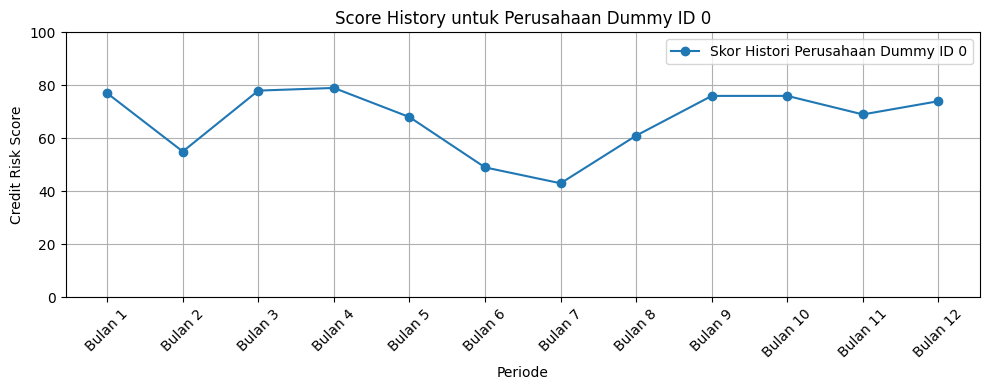

In [8]:
# 3. Score History (per applicant) - Data Dummy
applicant_ids = [company_name_sample, "Perusahaan B", "Perusahaan C"]
score_history_data = {
    company_name_sample: np.random.randint(30, 90, size=12),
    "Perusahaan B": np.random.randint(40, 100, size=12),
    "Perusahaan C": np.random.randint(20, 70, size=12)
}
months = [f"Bulan {i+1}" for i in range(12)]

plt.figure(figsize=(10, 4))
plt.plot(months, score_history_data[company_name_sample], marker='o', label=f"Skor Histori {company_name_sample}")
plt.title(f"Score History untuk {company_name_sample}")
plt.xlabel("Periode")
plt.ylabel("Credit Risk Score")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
score_history_plot = plt.gcf()
plt.show()

# 4. Approval Recommendation
recommendation = ""
recommendation_icon = ""
if risk_category == "Low Risk":
    recommendation = "Approve"
    recommendation_icon = "✔️"
elif risk_category == "Medium Risk":
    recommendation = "Butuh Review Lanjutan"
    recommendation_icon = "🟡"
else:
    recommendation = "Decline"
    recommendation_icon = "❌"
    
# Buat box untuk analisis perusahaan, agar label berada di dalam box yang rapi
analisis_box = widgets.VBox(
    [
        widgets.HTML(
            value=f"<b>Analisis untuk Perusahaan:</b> {company_name_sample}",
            layout=widgets.Layout(margin='0px 0px 5px 0px')
        )
    ],
    layout=widgets.Layout(
        border='1px solid #ccc',
        padding='10px',
        background_color='#f9f9f9',
        width='100%'
    )
)

# Tambahkan widget rekomendasi ke dalam analisis_box
rekomendasi_html = widgets.HTML(
    value=f"<b>Rekomendasi:</b> {recommendation_icon} {recommendation}",
    layout=widgets.Layout(margin='5px 0px 0px 0px')
)
analisis_box.children = list(analisis_box.children) + [
    widgets.Label("Credit Risk Score:"),
    score_gauge,
    risk_label,
    rekomendasi_html
]
display(analisis_box)


In [9]:
import json
import pandas as pd
import numpy as np

# Fungsi untuk menghitung M-Score berdasarkan data keuangan
def calculate_m_score(financial_data):
    # Contoh sederhana, sesuaikan dengan logika perhitungan M-Score yang sebenarnya
    laba_bersih = financial_data.get("Laba tahun berjalan", 0)
    ekuitas = financial_data.get("Jumlah ekuitas", 0)
    
    if laba_bersih > 0 and ekuitas > 100000000000000: # Contoh batas
        return 'A' # Risiko sangat rendah
    elif laba_bersih > 0:
        return 'B' # Risiko rendah
    elif ekuitas < 50000000000000: # Contoh batas
        return 'D' # Risiko sangat tinggi
    else:
        return 'C' # Risiko sedang

# Pastikan companies_df dan restricted_df sudah ada dari sel sebelumnya.
# Jika tidak, PRABU.ipynb akan error sebelum mencapai sel ini.
# Kita asumsikan restricted_df sudah dibuat dengan balancing awal berdasarkan MScore.2019.int

try:
    with open('Output/Sarana/hasil_ekstraksi_semua_dokumen.json', 'r') as f:
        sarana_output = json.load(f)
    
    if sarana_output and len(sarana_output) > 0:
        # Pemetaan M-Score dari Sarana ke restricted_df
        # Kita butuh kolom 'Company name' di restricted_df untuk pemetaan ini.
        # companies_df (sumber dari restricted_df) memiliki 'Company name'.
        
        m_scores_from_sarana = {}
        # Membuat pemetaan dari nama file dokumen (kunci di sarana_output) ke M-Score
        # Ini adalah asumsi, idealnya ada ID perusahaan yang jelas
        # Untuk contoh ini, kita akan mencoba mencocokkan nama perusahaan jika ada,
        # atau menerapkan M-Score pertama ke beberapa perusahaan dummy jika tidak ada pencocokan.
        
        # Ambil nama perusahaan unik dari companies_df yang sudah dimuat
        if 'companies_df' in locals() and not companies_df.empty and 'Company name' in companies_df.columns:
            available_company_names = companies_df['Company name'].unique()
            
            for i, entry in enumerate(sarana_output):
                # Cobalah untuk mendapatkan nama perusahaan dari entry['nama_file'] atau ID lain jika ada
                # Untuk saat ini, kita akan petakan secara berurutan ke perusahaan yang ada
                if i < len(available_company_names):
                    company_to_update = available_company_names[i]
                    calculated_m_score = calculate_m_score(entry['hasil_ekstraksi'])
                    m_scores_from_sarana[company_to_update] = calculated_m_score
        else:
            print("companies_df tidak tersedia atau tidak punya 'Company name', tidak bisa memetakan M-Score dari Sarana secara spesifik.")

        # Update MScore.2020 di restricted_df
        if 'restricted_df' in locals() and not restricted_df.empty and 'Company name' in restricted_df.columns and m_scores_from_sarana:
            updated_count = 0
            for index, row in restricted_df.iterrows():
                company_name = row['Company name']
                if company_name in m_scores_from_sarana:
                    new_mscore = m_scores_from_sarana[company_name]
                    restricted_df.loc[index, 'MScore.2020'] = new_mscore
                    restricted_df.loc[index, 'MScore.2020.int'] = 0 if new_mscore.lower() in ['a', 'b'] else 1
                    updated_count +=1
            if updated_count > 0:
                print(f"Kolom M-Score.2020 telah diperbarui untuk {updated_count} perusahaan di restricted_df menggunakan data dari Output/Sarana.")
            else:
                print("Tidak ada perusahaan di restricted_df yang cocok dengan nama dari output Sarana untuk pembaruan MScore.2020.")
                # Jika tidak ada yang diupdate, buat M-Score dummy untuk kolom MScore.2020
                dummy_m_scores_2020 = np.random.choice(['A', 'B', 'C', 'CC', 'CCC', 'D'], size=len(restricted_df))
                restricted_df['MScore.2020'] = dummy_m_scores_2020
                restricted_df['MScore.2020.int'] = restricted_df['MScore.2020'].apply(lambda x: 0 if str(x).lower() in ['a', 'b'] else 1)
                print("Kolom M-Score.2020 dummy telah dibuat untuk restricted_df karena tidak ada pembaruan dari Sarana.")

        elif 'restricted_df' in locals() and not restricted_df.empty: # Jika restricted_df ada tapi tidak bisa memetakan
            print("Tidak dapat memetakan M-Score dari Sarana ke restricted_df. Membuat M-Score.2020 dummy.")
            dummy_m_scores_2020 = np.random.choice(['A', 'B', 'C', 'CC', 'CCC', 'D'], size=len(restricted_df))
            restricted_df['MScore.2020'] = dummy_m_scores_2020
            restricted_df['MScore.2020.int'] = restricted_df['MScore.2020'].apply(lambda x: 0 if str(x).lower() in ['a', 'b'] else 1)
        else:
            print("restricted_df kosong. Pembaruan M-Score.2020 dari Sarana dilewati.")
            
    else: # Jika sarana_output kosong atau file tidak ditemukan
        raise FileNotFoundError 

except FileNotFoundError:
    print("File Output/Sarana/hasil_ekstraksi_semua_dokumen.json tidak ditemukan atau kosong.")
    if 'restricted_df' in locals() and not restricted_df.empty:
        print("Membuat data M-Score.2020 dummy untuk restricted_df.")
        dummy_m_scores_2020 = np.random.choice(['A', 'B', 'C', 'CC', 'CCC', 'D'], size=len(restricted_df))
        restricted_df['MScore.2020'] = dummy_m_scores_2020
        restricted_df['MScore.2020.int'] = restricted_df['MScore.2020'].apply(lambda x: 0 if str(x).lower() in ['a', 'b'] else 1)
    else:
        print("restricted_df tidak tersedia atau kosong. Pembuatan M-Score.2020 dummy dilewati.")

# Re-balancing restricted_df berdasarkan MScore.2019.int (setelah MScore.2020 mungkin sudah diupdate)
# Ini dilakukan karena MScore.2019.int adalah fitur input untuk beberapa model di notebook training
if 'restricted_df' in locals() and not restricted_df.empty and 'MScore.2019.int' in restricted_df.columns:
    # Pastikan MScore.2019.int ada dan memiliki variasi untuk balancing
    if restricted_df['MScore.2019.int'].nunique() > 1:
        high_risk_df_rebal = restricted_df[restricted_df['MScore.2019.int'] == 1]
        low_risk_df_rebal = restricted_df[restricted_df['MScore.2019.int'] == 0]

        if not high_risk_df_rebal.empty and not low_risk_df_rebal.empty:
            n_sample_rebal = min(len(high_risk_df_rebal), len(low_risk_df_rebal))
            
            high_risk_df_sampled_rebal = high_risk_df_rebal.sample(n=n_sample_rebal, random_state=0)
            low_risk_df_sampled_rebal = low_risk_df_rebal.sample(n=n_sample_rebal, random_state=0)
            
            restricted_df_balanced = pd.concat([low_risk_df_sampled_rebal, high_risk_df_sampled_rebal])
            restricted_df_balanced.sort_index(inplace=True)
            
            # Cek apakah restricted_df perlu diupdate atau sudah seimbang dari awal
            if len(restricted_df_balanced) < len(restricted_df):
                 restricted_df = restricted_df_balanced
                 print("restricted_df telah di-rebalance berdasarkan MScore.2019.int.")
            else:
                 print("restricted_df sudah seimbang atau tidak memerlukan re-balancing berdasarkan MScore.2019.int.")
        else:
            print("Tidak cukup data di kedua kelas MScore.2019.int untuk re-balancing.")
    else:
        print("Tidak ada cukup variasi di MScore.2019.int untuk re-balancing.")
elif 'restricted_df' in locals() and not restricted_df.empty:
    print("Kolom 'MScore.2019.int' tidak ada di restricted_df, re-balancing tidak dilakukan.")
else:
    print("restricted_df tidak didefinisikan atau kosong, tidak ada operasi M-Score atau balancing yang dilakukan.")

# Tampilkan hasil untuk verifikasi jika restricted_df ada
if 'restricted_df' in locals() and not restricted_df.empty:
    print("\nSample restricted_df setelah potensi update MScore.2020 dan re-balancing MScore.2019.int:")
    print(restricted_df.head())
    if 'MScore.2019.int' in restricted_df.columns:
        print("\nDistribusi MScore.2019.int:")
        print(restricted_df['MScore.2019.int'].value_counts())
    if 'MScore.2020.int' in restricted_df.columns:
        print("\nDistribusi MScore.2020.int:")
        print(restricted_df['MScore.2020.int'].value_counts())
else:
    print("\nrestricted_df tidak ada atau kosong, tidak ada output data.")


Kolom M-Score.2020 telah diperbarui untuk 1 perusahaan di restricted_df menggunakan data dari Output/Sarana.
restricted_df sudah seimbang atau tidak memerlukan re-balancing berdasarkan MScore.2019.int.

Sample restricted_df setelah potensi update MScore.2020 dan re-balancing MScore.2019.int:
               Company name  Turnover.2020  Turnover.2019  Turnover.2018  \
0          LENDLEASE S.R.L.          29458          16716           9612   
4             PANFERTIL SPA          45948          47336          45626   
7   MALLINCKRODT DAR S.R.L.          41549          42260          42928   
11                    EKIPA          42529          38168          35518   
16               SVI S.P.A.          49976          41149          32655   

    Turnover.2017  Turnover.2016  Turnover.2015  EBIT.2020  EBIT.2019  \
0            8097         7941.0         5600.0    -1556.0    -4540.0   
4           48222        57074.0        62263.0       44.0      713.0   
7           44801        44521.